In [1]:
import pandas as pd
import numpy as np
import scipy as scp
import geopy # pip install geopy if necessary
import seaborn as sns # for visualization

In [2]:
data = pd.read_csv('../openfoodfacts.csv',delimiter='\t',low_memory=False)

In [3]:
print(data.shape)

(681602, 173)


In [8]:
data["countries_en"].value_counts().shape

(1361,)

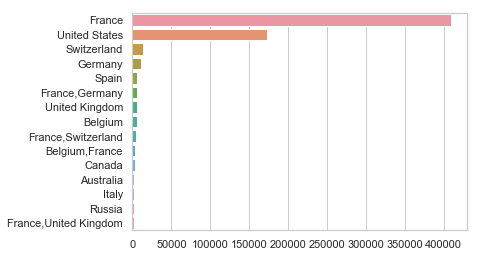

In [5]:
country_count = data["countries_en"].value_counts()[0:15]

sns.set(style="whitegrid")
sns.barplot(y=country_count.index, x=country_count.values)


In [6]:
us_product = data[data["countries_en"]=="United States"]
sel = ['categories_en', 'main_category_en', 'labels_en', 'origins_tags', 'manufacturing_places_tags', 
       'first_packaging_code_geo', 'countries_en']
us_product = us_product[sel]
us_product.head()

,categories_en,main_category_en,labels_en,origins_tags,manufacturing_places_tags,first_packaging_code_geo,countries_en
34,NaN,NaN,NaN,NaN,NaN,NaN,United States
35,NaN,NaN,NaN,NaN,NaN,NaN,United States
62,NaN,NaN,NaN,NaN,NaN,NaN,United States
63,NaN,NaN,NaN,NaN,NaN,NaN,United States
64,NaN,NaN,NaN,NaN,NaN,NaN,United States


Data from US are very incomplete ==> won't be useful for the analysis

# Data for distance computation

In [7]:
#a = ~data["first_packaging_code_geo"].isnull() # 27572
b = ~data["origins_tags"].isnull()
c = ~data["manufacturing_places_tags"].isnull()

sele = b | c  # 88001

data_loc = data[sele] # 57688 (88001)
# print(data_loc.shape) # (88001, 173)

sel = ['categories_en', 'main_category_en', 'labels_en', 'origins_tags', 'manufacturing_places_tags', 
       'first_packaging_code_geo', 'countries_en']

data_loc = data_loc[sel]
data_loc

,categories_en,main_category_en,labels_en,origins_tags,manufacturing_places_tags,first_packaging_code_geo,countries_en
106,Dietary supplements,Dietary supplements,Made in France,NaN,france,NaN,France
251,"Meals,Meat-based products,Meals with meat,Poul...",Meals,"fr:Viande Française,Made in France",france,france,NaN,France
254,"Plant-based foods and beverages,Plant-based fo...",Plant-based foods and beverages,NaN,quebec,brossard-quebec,NaN,Canada
264,"Sugary snacks,Biscuits and cakes,Pastries",Sugary snacks,NaN,quebec,brossard-quebec,NaN,Canada
269,"Plant-based foods and beverages,Plant-based fo...",Plant-based foods and beverages,NaN,france,united-kingdom,NaN,United Kingdom
274,"Sugary snacks,Biscuits and cakes,Pastries",Sugary snacks,NaN,quebec,brossard-quebec,NaN,Canada
285,fr:Boulange,fr:Boulange,NaN,quebec,"brossard,quebec",NaN,Canada
289,"Beverages,Carbonated drinks,Sodas,Sugared beve...",Beverages,"Kosher,Contains GMOs",NaN,etats-unis,NaN,"France,United States"
292,"Sugary snacks,Biscuits and cakes,Biscuits,Shor...",Sugary snacks,Green Dot,NaN,"france,avranches",NaN,France
296,"Meals,Pizzas pies and quiches,Quiches,Lorraine...",Meals,NaN,quebec,"brossard,quebec",NaN,Canada


## Destination
Split so that there is only 1 country remaining in "countries_en"

In [9]:
z = data_loc["countries_en"].str.split(',').apply(pd.Series)

In [10]:
z1 = z.unstack().dropna()

In [11]:
z1 = z1.to_frame()
z1.columns = ['destination']

In [12]:
z1.head()

destination
0 106          France
  251          France
  254          Canada
  264          Canada
  269  United Kingdom

In [13]:
# change destination with special characters
# manually checked on wikipedia + google maps
z1[z1['destination'] == 'Other-日本'] = 'Japon' # manually checked on wiki
z1[z1['destination'] == '中国'] = 'Chine'
z1[z1['destination'] == 'fr:香港'] = 'Hong Kong'
z1[z1['destination'] == 'fr:日本'] = 'Japon'
z1[z1['destination'] == 'Ελλάδα'] = 'Grèce'
z1[z1['destination'] == 'ar:صنعاء'] = 'Sanaa'
z1[z1['destination'] == 'fr:الجزائر'] = 'Algérie'


In [14]:
# remove fr: or others xx: in destination

def split_xx(l):
    tmp = l.split(':')
    
    if len(tmp) == 1:
        return l
    else:
        return tmp[1]
        
z1['destination'] = z1['destination'].apply(lambda l: split_xx(l))

In [15]:
print(z1.shape)
z1 = z1[~(z1 == 'Photos uploaded')]
z1 = z1[~(z1 == 'Photos validated')]
z1 = z1[~(z1 == 'Product name completed')]
z1 = z1[~(z1 == 'Photos to be uploaded')]
z1 = z1[~(z1 == 'Photos to be validated')]
z1 = z1[~(z1 == 'Quantity completed')]
z1 = z1[~(z1 == 'Nutrition facts completed')]
z1 = z1[~(z1 == 'Ingredients completed')]
z1 = z1[~(z1 == 'Brands completed')]
z1 = z1[~(z1 == 'Packaging completed')]
z1 = z1[~(z1 == 'Characteristics completed')]
z1 = z1[~(z1 == 'Categories completed')]
z1 = z1[~(z1 == 'Packaging-code-completed')]
z1 = z1[~(z1 == 'Expiration date completed')]
z1 = z1[~(z1 == 'Expiration date to be completed')]
z1 = z1[~(z1 == 'En')]
z1 = z1[~(z1 == 'To be completed')]
z1 = z1[~(z1 == 'To be checked')]
z1 = z1[~(z1 == 'Worldwide')]
z1 = z1[~(z1 == 'World')]
z1 = z1[~(z1 == 'Sucre')]
z1 = z1[~(z1 == 'Complete')]
z1 = z1[~(z1 == 'Global-market')]
z1 = z1[~(z1 == 'Dat')]
z1 = z1[~(z1 == 'France-others')]

z1 = z1.dropna()
print(z1.shape)
#z1 = z1.to_frame()

(89510, 1)
(88959, 1)


In [16]:
# replace values manually
z1[z1['destination'] == 'Leclerc-bois-d-arcy-france'] = 'France'
z1[z1['destination'] == 'Francecontient-des-sulfites'] = 'France'
z1[z1['destination'] == 'Leclerc'] = 'France'
z1[z1['destination'] == 'Auchan'] = 'France'
z1[z1['destination'] == 'Carrefour'] = 'France'
z1[z1['destination'] == 'Estadps-unidos'] = 'United States'
z1[z1['destination'] == 'Polyensie-francaise'] = 'French Polynesia'



In [18]:
z1['destination'].unique().shape

(238,)

In [22]:
z1['destination'].unique()

array(['France', 'Canada', 'United Kingdom', 'Germany', 'Spain',
       'United States', 'Belgium', 'Australia', 'Egypt', 'Haiti',
       'Mexico', 'Italy', 'Switzerland', 'Saudi Arabia', 'Greece',
       'Netherlands', 'Jordan', 'Hong Kong', 'Denmark',
       'French Polynesia', 'European Union', 'Serbia', 'New Caledonia',
       'United Arab Emirates', 'Cuba', 'Argentina', 'Mauritius',
       'Morocco', 'Sweden', 'Thailand', 'China',
       'Saint Pierre and Miquelon', 'Quebec', 'Czech Republic', 'Austria',
       'India', 'Turkey', 'Cambodia', 'Portugal', 'Colombia', 'Réunion',
       'Burkina Faso', 'Algeria', 'Russia', 'Oman', 'Brazil',
       'Costa Rica', 'Romania', 'Democratic Republic of the Congo',
       'Cyprus', 'Japan', 'Cameroon', 'Lebanon', 'Philippines', 'Ecuador',
       'South Africa', 'Israel', 'Chile', 'Taiwan', 'Dominica', 'Myanmar',
       'Peru', 'Indonesia', 'Finland', 'Poland', 'Lithuania', 'Ireland',
       'Senegal', "Côte d'Ivoire", 'Togo', 'Iceland', 'Sout

Several countries are represented twice (or more) with the name of the country in different languages. ex. Greece and Grèce are the same country. Thus the count of the product for both shoud be added.

In [43]:
z1["destination"].value_counts().shape

(238,)

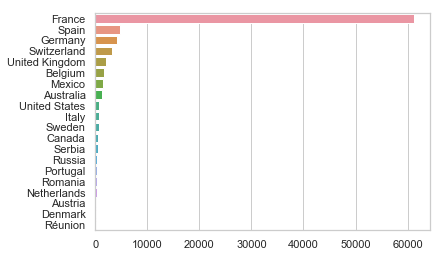

In [21]:
country_count = z1["destination"].value_counts()[0:20]

sns.set(style="whitegrid")
sns.barplot(y=country_count.index, x=country_count.values)

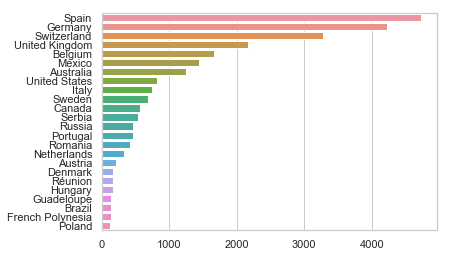

In [36]:
country_count = z1["destination"].value_counts()[1:25]

sns.set(style="whitegrid")
sns.barplot(y=country_count.index, x=country_count.values)

## Make a dico to have unique countries ==> find country name in english

In [29]:
dico = pd.read_csv('data/Destination-Coordinate-MAN.csv',delimiter=',',low_memory=False)
dico.head()

,Unnamed: 0,Unnamed: 0.1,destination,country
0,0,France,France,France
1,1,Spain,Spain,Spain
2,2,Germany,Germany,Germany
3,3,Switzerland,Switzerland,Switzerland
4,4,United Kingdom,United Kingdom,United Kingdom


In [30]:
dictionary_country = dict(zip(dico['destination'], dico['country']))
dictionary_country

{'France': 'France',
 'Spain': 'Spain',
 'Germany': 'Germany',
 'Switzerland': 'Switzerland',
 'United Kingdom': 'United Kingdom',
 'Belgium': 'Belgium',
 'Mexico': 'Mexico',
 'Australia': 'Australia',
 'United States': 'USA',
 'Italy': 'Italy',
 'Sweden': 'Sweden',
 'Canada': 'Canada',
 'Serbia': 'Serbia',
 'Portugal': 'Portugal',
 'Russia': 'Russia',
 'Romania': 'Romania',
 'Netherlands': 'Netherlands',
 'Austria': 'Austria',
 'Denmark': 'Denmark',
 'Réunion': 'France',
 'Hungary': 'Hungary',
 'Guadeloupe': 'France',
 'Brazil': 'Brazil',
 'French Polynesia': 'France',
 'Hong Kong': 'Hong Kong',
 'Poland': 'Poland',
 'Madagascar': 'Madagascar',
 'Ireland': 'Ireland',
 'Tunisia': 'Tunisia',
 'New Zealand': 'New Zealand',
 'India': 'India',
 'South Africa': 'RSA',
 'Luxembourg': 'Luxembourg',
 'French Guiana': 'France',
 'Georgia': 'USA',
 'Deutschland': 'Germany',
 'Czech Republic': 'Czechia',
 'Morocco': 'Morocco',
 'Algeria': 'Algeria',
 'Martinique': 'France',
 'Greece': 'Greece',
 

## Apply to the products

In [31]:
z1_safe = z1
z1.head()

destination
0 106          France
  251          France
  254          Canada
  264          Canada
  269  United Kingdom

In [555]:
z1.shape

(96837, 2)

In [34]:
z1.head()

destination
0 106          France
  251          France
  254          Canada
  264          Canada
  269  United Kingdom

In [33]:
# test
dictionary_country['Verenigd-koninkrijk']

'United Kingdom'

In [37]:
z1['Arrival'] = z1['destination'].apply(lambda l: dictionary_country[l])

In [38]:
print(z1['Arrival'].shape)
z1 = z1[z1['Arrival'] != 'NaN']
print(z1['Arrival'].shape)

(88959,)
(88959,)


In [39]:
count = z1['Arrival'].value_counts()

In [44]:
z1["Arrival"].value_counts().shape

(134,)

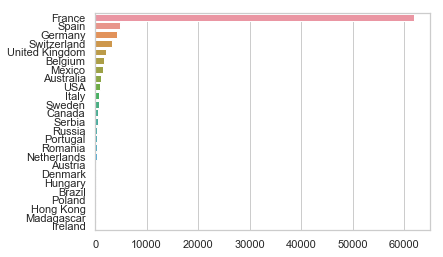

In [41]:
country_count = z1["Arrival"].value_counts()[0:25]

sns.set(style="whitegrid")
sns.barplot(y=country_count.index, x=country_count.values)

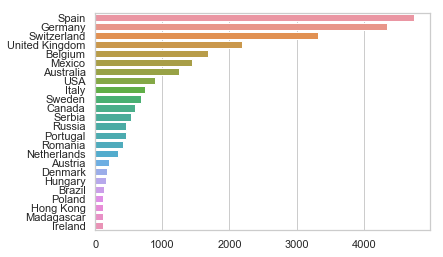

In [42]:
country_count = z1["Arrival"].value_counts()[1:25]

sns.set(style="whitegrid")
sns.barplot(y=country_count.index, x=country_count.values)